## Normal Setup

Perform a normal setup as you otherwise would. Adjust the platform & target as needed. Here we'll attack an XMEGA device on the CW308 UFO board for example. Note that because the UFO boards are missing the decoupling capacitors & have a resistive shunt, you may find they perform *worse* for H-Field probe usage than normal development kits.

Neverless, we're going to give it a shot! We found the XMEGA works better than the STM32F3 target on the UFO board, so we'll do this tutorial with the XMEGA target board.

In [1]:
 %load_ext autotime

SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'TINYAES128C'
num_traces = 100
CHECK_CORR = False

time: 318 µs (started: 2022-04-15 14:35:37 -04:00)


In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd /home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1]: Entering directory '/home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes'
Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes.d aes-independant.d
rm -f -- simple

In [3]:
%run "/home/ucsec/hl/chipwhisperer-jupyter/Setup_Scripts/Setup_Generic.ipynb"

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍
time: 915 ms (started: 2022-04-15 14:35:37 -04:00)


In [4]:
fw_path = '/home/ucsec/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex'.format(PLATFORM)

time: 800 µs (started: 2022-04-15 14:35:38 -04:00)


In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4263 bytes
time: 699 ms (started: 2022-04-15 14:35:38 -04:00)


In [6]:
scope.gain.gain = 70

time: 2.61 ms (started: 2022-04-15 14:35:39 -04:00)


## Visual Capture Loop

Now adjusting the H-Field probe around, you can find an interesting location. The following loop will run up to 5000 captures, but throws them away. Just stop the loop if you find a good physical location (traces look stable). This might not be super-obvious: you'll see how to run a CPA attack next.

## Actual Capture Loop & Analysis

Then run the following two blocks - if the results aren't good, try another location!

In [7]:
import numpy as np
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa
from imp import reload 
import em_collection_StreamingMode_ps3000a
reload(em_collection_StreamingMode_ps3000a)

#project = cw.create_project("projects/hfield_demo.cwp", overwrite = True)

from tqdm import tnrange
ktp = cw.ktp.Basic()

## define val to store data (trace,text,key)
power_trace, plain_text = [],[]

for i in tnrange(num_traces, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    
    #trace = cw.capture_trace(scope, target, text, key)
    trace = em_collection_StreamingMode_ps3000a.data_collect()
    if trace is None:
        continue
    
    power_trace.append(np.array(trace,dtype=np.float32))
    plain_text.append(np.array(text))

key = key  ## as key in all iterations are the same
power_trace = np.array(power_trace,dtype=np.float32)
plain_text = np.array(plain_text)
key = np.array(key)

/tmp/ipykernel_390535/1538906240.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/tmp/ipykernel_390535/1538906240.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(num_traces, desc='Capturing traces'):


Capturing traces:   0%|          | 0/100 [00:00<?, ?it/s]

time: 9min 6s (started: 2022-04-15 14:35:39 -04:00)


In [8]:
## save the results into npz file
import numpy as np
import os

output_path = './results/em_trace_capture/'
os.makedirs(output_path,exist_ok=True)

np.savez(os.path.join(output_path,'trace_plaintext_key.npz'),power_trace=power_trace,plain_text=plain_text,key=key)
print(f"shape of power trace {np.array(power_trace).shape}")
print(f"shape of plain text {np.array(plain_text).shape}")
print(f"shape of key {np.array(key).shape}")
print(f"Data saved successfully in {os.path.join(output_path,'trace_plaintext_key.npz')}!")

shape of power trace (100, 5000)
shape of plain text (100, 16)
shape of key (16,)
Data saved successfully in ./results/em_trace_capture/trace_plaintext_key.npz!
time: 5.11 ms (started: 2022-04-15 14:44:45 -04:00)


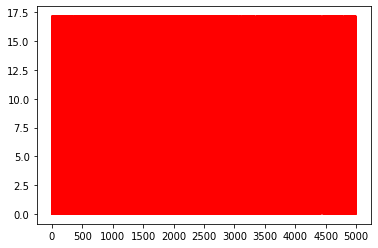

time: 259 ms (started: 2022-04-15 14:44:45 -04:00)


In [9]:
## plot the last trace 

%matplotlib notebook
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(power_trace[-1], color='r')

In [10]:
## disconnect device
scope.dis()
target.dis()

time: 602 µs (started: 2022-04-15 14:44:45 -04:00)


In [11]:
print(power_trace)
print(plain_text)
print(key)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [17.162893  0.        0.       ...  0.       17.162893 17.162893]
 ...
 [ 0.       17.162893 17.162893 ...  0.       17.162893 17.162893]
 [ 0.       17.162893 17.162893 ...  0.        0.        0.      ]
 [ 0.       17.162893  0.       ... 17.162893  0.        0.      ]]
[[ 65 193 255 ...  19 192 251]
 [ 14 115  56 ... 197 233 151]
 [ 79 194 235 ... 172 140 201]
 ...
 [ 95 254 142 ... 161 161 111]
 [166 226  95 ...  51  89  46]
 [237 201 211 ... 179 132 169]]
[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
time: 1.34 ms (started: 2022-04-15 14:44:45 -04:00)
